# Capstone Project - Tourist Map for Hamburg

Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import requests
import json
import math
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
import branca 
import seaborn as sns
from shapely.ops import cascaded_union
import branca.colormap as cmp
from branca.element import Template, MacroElement
from math import sin, cos, sqrt, atan2, radians



<br>
<br>
<br>

# Part I: Data Collection and Wrangling

Reading in Data for Hamburg Districts from "https://www.statistik-nord.de/zahlen-fakten/regionalstatistik-datenbanken-und-karten/hamburger-stadtteil-profile-staedtestatistik-fuer-hamburg". The dataframe contains information about the area size per neighborhood, the inhabitant density per neighborhood and some other socioeconometrical data, which we're not going to use here.  

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
districts = pd.read_excel("Stadtteilprofile2020_Datentabelle_Berichtsjahr2019.xlsx", sep = ";", encoding = "utf8", error_bad_lines = False, header = 1).drop(0, axis = 0)
districts.rename(columns = {'Unnamed: 0' : 'Stadtgebiete'}, inplace = True)
districts = districts.iloc[:99,:]
hamburg = districts[['Stadtgebiete', 'Bevölkerung', 'Fläche in km²', 'Bevölkerungs-dichte', 'Zuzüge', 'Fortzüge', 'Preise für Eigentums-wohnungen in EUR/m² (Jan 2020)']]
hamburg.sort_values('Stadtgebiete', inplace = True, ignore_index = True)
hamburg.head(5)

,Stadtgebiete,Bevölkerung,Fläche in km²,Bevölkerungs-dichte,Zuzüge,Fortzüge,Preise für Eigentums-wohnungen in EUR/m² (Jan 2020)
0,Allermöhe,1377,8.63736,159,171,159,.
1,Alsterdorf,15204,3.15524,4819,1846,1816,5636
2,Altengamme,2296,15.6082,147,232,169,.
3,Altona-Altstadt,29170,2.71787,10733,3258,3458,5977
4,Altona-Nord,24536,2.21782,11063,3454,3321,5977


Calling the ESRI Germany API to retrieve the GeoJSON-file for Hamburg districts and saving it to a JSON-file

In [5]:
url = "https://services2.arcgis.com/jUpNdisbWqRpMo35/arcgis/rest/services/HH_ALKIS_Stadtteile_2016/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
geo = requests.get(url).json()

with open('geo.json', 'w') as json_file:
    json.dump(geo, json_file)
geo = gpd.read_file('geo.json')

In the dataframe from our first source, some of the districts are connected. Because of that, we need to connect the respective polygons in our JSON file. We do this with the "cascaded_union"-command for both polygons of the two connected areas. Further, there are some encoding problems, because of which we cannot merge the two dataframes. We will therefore rename those Neighborhoods that were encoded wrongly, as well as those who are merged in the first dataframe. We finally merge the two dataframes and drop two peripheral Neighborhoods, that do not appear in the dataframe from the first source. 

In [6]:
# Connecting the Polygons

geo = geo.set_index('stadtteil')
merged_districts = [('Altenwerder','Moorburg'),('Finkenwerder', 'Waltershof'), ('Kleiner Grasbrook', 'Steinwerder'), ('Neuland', 'Gut Moor')]

for districts in merged_districts:
    polygons = [geo.loc[districts[0],'geometry'],geo.loc[districts[1],'geometry']]
    boundary = gpd.GeoSeries(cascaded_union(polygons))
    geo.loc[districts[0],'geometry'] = boundary[0]
    geo = geo.drop(districts[1],axis = 0)


# Renaming wrongly encoded and merged Neighborhoods

geo.reset_index(inplace = True)
geo['stadtteil'][geo['stadtteil'] == 'Altenwerder'] = 'Moorburg und Altenwerder'
geo['stadtteil'][geo['stadtteil'] == 'Barmbek-Sod'] = 'Barmbek-Süd'
geo['stadtteil'][geo['stadtteil'] == 'Finkenwerder'] = 'Waltershof und Finkenwerder'
geo['stadtteil'][geo['stadtteil'] == 'Grob Borstel'] = 'Groß Borstel'
geo['stadtteil'][geo['stadtteil'] == 'Grob Flottbek'] = 'Groß Flottbek'
geo['stadtteil'][geo['stadtteil'] == 'Kleiner Grasbrook'] = 'Kleiner Grasbrook und Steinwerder'
geo['stadtteil'][geo['stadtteil'] == 'Neuallerm'] = 'Neuallermöhe'
geo['stadtteil'][geo['stadtteil'] == 'Neuland'] = 'Neuland und Gut Moor'
geo['stadtteil'][geo['stadtteil'] == 'Rlnneburg'] = 'Rönneburg'
geo['stadtteil'][geo['stadtteil'] == 'St.Georg'] = 'St. Georg'
geo['stadtteil'][geo['stadtteil'] == 'St.Pauli'] = 'St. Pauli'
geo['stadtteil'][geo['stadtteil'] == 'Sllldorf'] = 'Sülldorf'


#Joining both dataframes and saving them

join = geo.merge(hamburg, how = 'left', left_on = 'stadtteil', right_on = 'Stadtgebiete')
join.to_file("hamburg_.json", driver="GeoJSON")
with open('hamburg_.json', 'r') as j:
     contents = json.loads(j.read())
    

# Dropping the two mentioned cases

join.reset_index()
join = join.drop([24,64], axis = 0)

<br>
<br>
<br>

# Part II: Clustering in Hamburg

Setting my credentials for the Foursquare API as well as the retrieval limit:

In [7]:
CLIENT_ID = 'RUKMAZKNGQ1HS5HKFP5LO4GS5T2GLW54P3ZKQNRGXVHZGI22' # your Foursquare ID
CLIENT_SECRET = '3Q0DM5NMNNGL14GJQAETVEYO0XLKXVB3VFAVSHYXKPZ3MCBQ' # your Foursquare Secret
ACCESS_TOKEN = 'LII3I5BDGRNT5OAZFNMP1KEJDPY2W31TFE3N32ZCQ432OELV' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 1000

To retrieve every single Neighborhood (also the single Neighborhoods of the 4 merged Neighborhoods), we're dividing those Neighborhoods that contain an "und" and assign each Neighborhood an own row with the respective single polygon information from our GeoJSON file. We do this to later calculate the Coordinated from the single Polygons in order to be able to retrieve every single Neighborhood seperated from the Foursquare API. We finally compute the centers of each Neighborhood by computing the centers of polygons from the GeoJSON file.

In [8]:
hamburg_clean = pd.DataFrame(columns = ['Stadtgebiet', 'Bezirk', 'Fläche', 'geometry'])
geo_2 = gpd.read_file('geo.json')

for index in join.index:
    district = join.loc[index,'Stadtgebiete']
    quarter = join.loc[index,'bezirk']
    area = join.loc[index,'Fläche in km²']
    geometry = join.loc[index,'geometry']
    if 'und' in district:
        nh1 = district.split('und')[0].strip(" ")
        nh2 = district.split('und')[1].strip(" ")
        geometry_1 = geo_2['geometry'][geo_2['stadtteil'] == nh1][[geo_2.index[geo_2['stadtteil'] == nh1]][0][0]]
        geometry_2 = geo_2['geometry'][geo_2['stadtteil'] == nh2][[geo_2.index[geo_2['stadtteil'] == nh2]][0][0]]
        hamburg_clean = hamburg_clean.append({'Stadtgebiet': nh1, 'Bezirk': quarter, 'Fläche': area / 2, 'geometry': geometry_1}, ignore_index = True)
        hamburg_clean = hamburg_clean.append({'Stadtgebiet': nh2, 'Bezirk': quarter,  'Fläche': area / 2, 'geometry': geometry_2}, ignore_index = True)
    else:
       hamburg_clean = hamburg_clean.append({'Stadtgebiet': district, 'Bezirk': quarter, 'Fläche': area, 'geometry': geometry}, ignore_index = True)


# Computing Neighborhood centers

gdf = gpd.GeoDataFrame(hamburg_clean)
hamburg_clean["lat"] = gdf.centroid.y
hamburg_clean["lon"] = gdf.centroid.x

Retrieving the Foursquare API

In [9]:
hamburg_venues = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Category', 'Venue Lat', 'Venue Lon'])


for name, area, lat, lng in zip(hamburg_clean['Stadtgebiet'], hamburg_clean['Fläche'], hamburg_clean['lat'], hamburg_clean['lon']):
    radius =  int(sqrt(area / math.pi) * 1000)
    print(name,': ', str(radius))
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for v in results: 
        hamburg_venues = hamburg_venues.append({'Neighborhood': name, 'Neighborhood Latitude': lat, 'Neighborhood Longitude': lng, 'Venue Name': v['venue']['name'], 'Venue Category': v['venue']['categories'][0]['name'], 'Venue Lat': v['venue']['location']['lat'], 'Venue Lon': v['venue']['location']['lng']}, ignore_index = True)

NameError: name 'sqrt' is not defined

In [74]:
hamburg_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Lat,Venue Lon
0,Allermöhe,53.483214,10.133346,Wutzrock,Event Space,53.483274,10.110406
1,Allermöhe,53.483214,10.133346,SpielScheune der Geschichten,Indoor Play Area,53.482528,10.154303
2,Allermöhe,53.483214,10.133346,Regattastrecke Dove-Elbe Allermöhe,Racetrack,53.482127,10.114627
3,Allermöhe,53.483214,10.133346,Olympiastützpunkt Rudern,Athletics & Sports,53.481758,10.113718
4,Allermöhe,53.483214,10.133346,Sportplatz 2000,Soccer Field,53.483544,10.153468


In [1022]:
radius_copy = hamburg_venues.copy()

In [1053]:
hamburg_venues.to_csv("hamburg_venues_radius.csv")

In [9]:
hamburg_venues = pd.read_csv('hamburg_venues_radius.csv').drop('Unnamed: 0', axis = 1)

Filtering gastronomic venues and building a solely gastronomic dataframe:

In [19]:
hamburg_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Lat,Venue Lon
0,Allermöhe,53.483214,10.133346,Wutzrock,Event Space,53.483274,10.110406
1,Allermöhe,53.483214,10.133346,SpielScheune der Geschichten,Indoor Play Area,53.482528,10.154303
2,Allermöhe,53.483214,10.133346,Regattastrecke Dove-Elbe Allermöhe,Racetrack,53.482127,10.114627
3,Allermöhe,53.483214,10.133346,Olympiastützpunkt Rudern,Athletics & Sports,53.481758,10.113718
4,Allermöhe,53.483214,10.133346,Sportplatz 2000,Soccer Field,53.483544,10.153468


In [10]:
keywords = ['Restaurant','BBQ','Bagel','Bakery','Bar','Beer','Bistro','Tea','Breakfast','Burger','Burrito','Café','Coffee','Cocktail','Deli','Bodega', 'Ice Cream','Diner','Food','Drink','Chicken','Yoghurt','Pub','Gastropub','Club','Pizza','Place','Poke','Salad','Steak', 'Sushi','Wine','Joint','Doner','Fish & Chips', ]

gastro = []
for i, cat in enumerate(hamburg_venues['Venue Category']):
    c = 0
    for word in keywords: 
        if word.lower() in cat.lower() and c == 0:
            gastro.append(True)
            c += 1
    if c == 0:
        gastro.append(False)
    

hamburg_gastro = hamburg_venues[gastro]
hamburg_gastro.reset_index(inplace = True)

In this step, we reduce the dimensionality of the single categories. We want to make a statement about the characteristics of a Neighborhood in terms of general gastronomical offer, not in specific cuisine types or specialized establishments. Therefore, were assigning each category to one of the following five categories:
- Restaurant
- Bar
- Café
- To Go
- Club

Let's define the Keywords for these five categories:

In [11]:
keywords_rest = ['Restaurant','BBQ','Bistro','Burger','Burrito','Chicken','Joint','Burrito','Deli','Bodega','Diner','Fish','Chicken','Pizza','Place','Poke','Salad','Steak','Sushi']
keywords_cafe = ['Breakfast','Tea','Café','Coffee']
keywords_togo = ['Bagel','Bakery','Burrito','Doner','Street Food','Food Truck','Food Court','Fish & Chips','Ice Cream','Yoghurt','Market']
keywords_bar = ['Bar','Beer','Cocktail','Drink','Pub','Gastropub','Wine']
keywords_club = ['Club']

hamburg_gastro.loc[:,'Restaurant'] = 0
hamburg_gastro.loc[:,'Bar'] = 0
hamburg_gastro.loc[:,'Cafe'] = 0
hamburg_gastro.loc[:,'To_Go'] = 0
hamburg_gastro.loc[:,'Club'] = 0

for i, cat in enumerate(hamburg_gastro['Venue Category']):
    for word in keywords_rest: 
        if word.lower() in cat.lower():
            hamburg_gastro.loc[i,'Restaurant'] = 1
    for word in keywords_bar: 
        if word.lower() in cat.lower():
            hamburg_gastro.loc[i,'Bar'] = 1
    for word in keywords_cafe: 
        if word.lower() in cat.lower():
            hamburg_gastro.loc[i,'Cafe'] = 1
    for word in keywords_togo: 
        if word.lower() in cat.lower():
            hamburg_gastro.loc[i,'To_Go'] = 1
    for word in keywords_club: 
        if word.lower() in cat.lower():
            hamburg_gastro.loc[i,'Club'] = 1

Recoding some establishments that belong to two categories:

In [12]:
hamburg_gastro.loc[:,'Check'] = hamburg_gastro.iloc[:,-5:].sum(axis=1)
hamburg_gastro['Restaurant'][hamburg_gastro['To_Go'] == 1] = 0
hamburg_gastro['Cafe'][hamburg_gastro['Venue Category'] == 'Steakhouse'] = 0
hamburg_gastro['Check'] = hamburg_gastro.iloc[:,-6:-1].sum(axis=1)
hamburg_gastro['Venue Category'][hamburg_gastro['Check'] == 2.0].value_counts()

Series([], Name: Venue Category, dtype: int64)

To account for duplicates from the Foursquare API, we are calculating the distance for each establishment to the neighborhoods it was retrieved from, to assign it to the correct Neighborhood. Then, we sort the dataframe according to distance to the neighborhood coordinates and drop all duplicates, except the frist ones. By doing this, we only keep the establishments that are closest to the respective neighborhood and are therefore correctly assinged.

In [13]:
# Calculating the distance to Neighborhood centers:

# approximate radius of earth in km
R = 6373.0

hamburg_gastro['Distance'] = pd.NA
distances = []
for i, lat1, lon1, lat2, lon2 in zip(range(len(hamburg_gastro)),hamburg_gastro['Neighborhood Latitude'], hamburg_gastro['Neighborhood Longitude'], hamburg_gastro['Venue Lat'], hamburg_gastro['Venue Lon']):

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
       
    distance = R * c
    distances.append(distance)

hamburg_gastro['Distance'] = distances



# Deduplication based on distance to Center of district

hamburg_gastro = hamburg_gastro.sort_values('Distance', ascending = True).drop_duplicates(subset=['Venue Name', 'Venue Lat','Venue Lon'], keep = 'first')

In [14]:
hamburg_gastro.shape

(1454, 15)

Now let's have a look at the number of establishments per Neighborhood. We do this to explore, whether the data makes sense according to own experience and knowledge about the city of Hamburg:

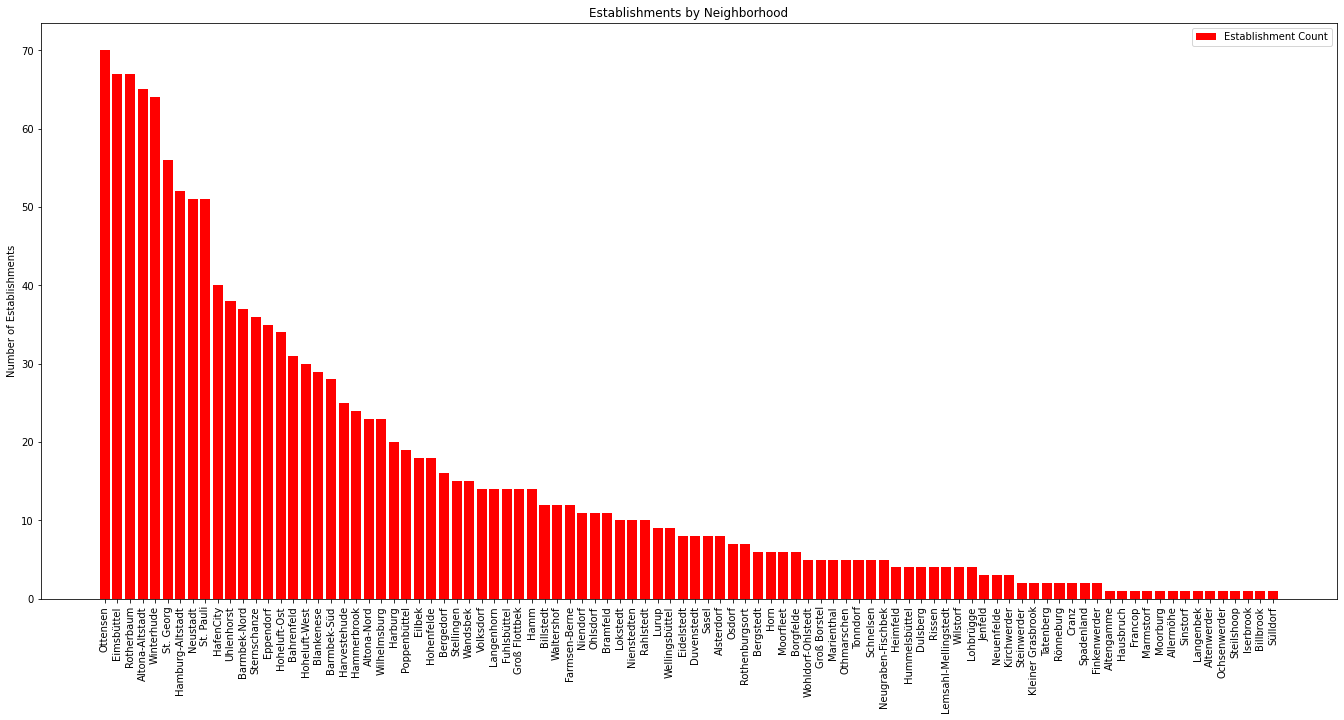

In [15]:
test = pd.DataFrame(hamburg_gastro['Neighborhood'].value_counts())
fig = plt.figure(figsize = (18,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(test.index, test['Neighborhood'], color='r')
ax.set_ylabel('Number of Establishments')
ax.set_title('Establishments by Neighborhood')
ax.legend(labels=['Establishment Count'])
ax.set_xticklabels(labels = test.index,rotation = 90)
plt.show()

In [ ]:
We see the most 

Now we are transforming the dataframe by grouping all entries by Neighborhood and summing the appearance of the 5 establishment categories:

In [16]:
hamburg_dummy = hamburg_gastro.iloc[:,-7:-2]
hamburg_dummy['Neighborhood'] = hamburg_gastro['Neighborhood']
hamburg_dummy = hamburg_dummy.groupby('Neighborhood').sum().reset_index()
hamburg_dummy.head()

,Neighborhood,Restaurant,Bar,Cafe,To_Go,Club
0,Allermöhe,0,0,0,0,1
1,Alsterdorf,5,0,1,2,0
2,Altengamme,1,0,0,0,0
3,Altenwerder,0,1,0,0,0
4,Altona-Altstadt,33,16,6,3,7


We further account for the connectedness of the merged regions mentioned before. We want to add entries of those areas, that are merged in the first source. To this ends, we first look in which of these Neighborhoods are we find establishments at all:

In [17]:
for i in list(('Moorburg','Altenwerder','Waltershof','Finkenwerder','Kleiner Grasbrook', 'Steinwerder', 'Neuland', 'Gut Moor')):
    try:
        print('{}: {}'.format(i,np.array(hamburg_dummy[hamburg_dummy['Neighborhood'] == i].iloc[:,1:])[0]))
    except:
        print('{}: Not included in Dataframe'.format(i))

Moorburg: [1 0 0 0 0]
Altenwerder: [0 1 0 0 0]
Waltershof: [5 2 2 3 0]
Finkenwerder: [1 0 0 1 0]
Kleiner Grasbrook: [1 0 0 1 0]
Steinwerder: [0 0 1 1 0]
Neuland: Not included in Dataframe
Gut Moor: Not included in Dataframe


Now we add the entries if both of the regions merged appear in the dataframe (Altenwerder and Moorburg). If not, we simply take the value of one of the regions that appears in the Foursquare data and rename it (Altershof und Finkenwerder & Kleiner Grasbrook und Steinwerder). If none of both regions appears, we do nothing (Neuland and Gut Moor).

In [18]:
#Moorburg und Altenwerder:
hamburg_dummy = hamburg_dummy.set_index('Neighborhood')
hamburg_dummy.loc['Moorburg'] += hamburg_dummy.loc['Altenwerder']
hamburg_dummy.drop('Altenwerder', axis = 0, inplace = True)
hamburg_dummy = hamburg_dummy.reset_index()
hamburg_dummy['Neighborhood'][hamburg_dummy['Neighborhood'] == 'Moorburg'] = 'Moorburg und Altenwerder'

#Waltershof und Finkenwerder
hamburg_dummy = hamburg_dummy.set_index('Neighborhood')
hamburg_dummy.loc['Waltershof'] += hamburg_dummy.loc['Finkenwerder']
hamburg_dummy.drop('Finkenwerder', axis = 0, inplace = True)
hamburg_dummy = hamburg_dummy.reset_index()
hamburg_dummy['Neighborhood'][hamburg_dummy['Neighborhood'] == 'Waltershof'] = 'Waltershof und Finkenwerder'

#Kleiner Grasbrook und Steinwerder
hamburg_dummy = hamburg_dummy.set_index('Neighborhood')
hamburg_dummy.loc['Steinwerder'] += hamburg_dummy.loc['Kleiner Grasbrook']
hamburg_dummy.drop('Kleiner Grasbrook', axis = 0, inplace = True)
hamburg_dummy = hamburg_dummy.reset_index()
hamburg_dummy['Neighborhood'][hamburg_dummy['Neighborhood'] == 'Steinwerder'] = 'Kleiner Grasbrook und Steinwerder'

#Neuland und Gut Moor:
#--

Building a complete dataframe which contains all information we will need from now on by merging both the dummy-coded Establishment data as well as the Geo-files and the data about hamburg city districts. The Neighborhoods for which we could not retrieve any information from Foursquare will be filled with Zeros, as the missing information simply means, that Foursquare does not have any information about establishments in that area, hence 0 establishments. 

In [19]:
# Merging all data

hamburg_total = join.merge(hamburg_dummy, how = "left", left_on = "Stadtgebiete", right_on = "Neighborhood")
hamburg_total.drop(['OBJECTID','Shape__Area','Shape__Length','Shape__Area_2','Shape__Length_2','Stadtgebiete'], axis = 1, inplace = True)

# Filling missing values with Zeros

hamburg_total.iloc[:,10:15] = hamburg_total.iloc[:,10:15].fillna(0)

In [47]:
hamburg_total.head()

,stadtteil,bezirk,geometry,Bevölkerung,Fläche in km²,Bevölkerungs-dichte,Zuzüge,Fortzüge,Preise für Eigentums-wohnungen in EUR/m² (Jan 2020),Neighborhood,Restaurant,Bar,Cafe,To_Go,Club,dist_center
0,Allermöhe,Bergedorf,"POLYGON ((10.12579 53.49475, 10.12632 53.49454...",1377,8.637358,159.0,171,159,.,Allermöhe,0.0,0.0,0.0,0.0,1.0,<NA>
1,Alsterdorf,Hamburg-Nord,"POLYGON ((10.01711 53.61587, 10.01807 53.61525...",15204,3.155241,4819.0,1846,1816,5636,Alsterdorf,5.0,0.0,1.0,2.0,0.0,<NA>
2,Altengamme,Bergedorf,"POLYGON ((10.26913 53.46785, 10.26971 53.46760...",2296,15.608172,147.0,232,169,.,Altengamme,1.0,0.0,0.0,0.0,0.0,<NA>
3,Moorburg und Altenwerder,Harburg,"POLYGON ((9.94261 53.50218, 9.94378 53.50107, ...",721,16.698194,43.0,45,72,.,Moorburg und Altenwerder,1.0,1.0,0.0,0.0,0.0,<NA>
4,Altona-Altstadt,Altona,"POLYGON ((9.94615 53.56273, 9.94685 53.56259, ...",29170,2.717873,10733.0,3258,3458,5977,Altona-Altstadt,33.0,16.0,6.0,3.0,7.0,<NA>


Now we are building a dataframe only containing the columns we need for Clustering. We are computing the **density** of all establishment categories, so dividing the number of appearances 

In [21]:
features = pd.DataFrame(columns = ['neighborhood','rest_density', 'bar_density', 'cafe_density', 'togo_denisty', 'club_density', 'inhabitant_density'])
hamburg_total['Fläche in km²'] = hamburg_total['Fläche in km²'].astype(float)
hamburg_total['Bevölkerungs-dichte'] = hamburg_total['Bevölkerungs-dichte'].astype(float)

features['neighborhood'] = hamburg_total['Neighborhood']
features['rest_density'] = round(hamburg_total['Restaurant'] / hamburg_total['Fläche in km²'],2)
features['bar_density'] = round(hamburg_total['Bar'] / hamburg_total['Fläche in km²'],2)
features['cafe_density'] = round(hamburg_total['Cafe'] / hamburg_total['Fläche in km²'],2)
features['togo_denisty'] = round(hamburg_total['To_Go'] / hamburg_total['Fläche in km²'],2)
features['club_density'] = round(hamburg_total['Club'] / hamburg_total['Fläche in km²'],2)
features['inhabitant_density'] = round(hamburg_total['Bevölkerungs-dichte'],2)
features_clean = features.drop(['neighborhood'], axis = 1)
for col in features_clean.columns:
    features_clean[col] = features_clean[col].astype(float)

Elbow method

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

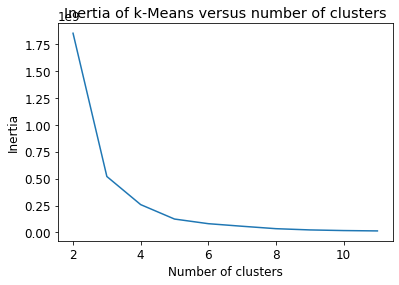

In [1041]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
scores = [KMeans(n_clusters=i+1).fit(features_clean).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(features_clean)

#Shwoing the clustering labels
kmeans.labels_[0:10] 

array([0, 4, 0, 0, 1, 1, 2, 1, 1, 2], dtype=int32)

In [32]:
hamburg_total['Cluster'] = kmeans.labels_
features_clean['Cluster'] = kmeans.labels_
for col in features_clean.columns:
    hamburg_total[col] = features_clean[col]
    
interpretation = features_clean.groupby('Cluster').mean().reset_index()

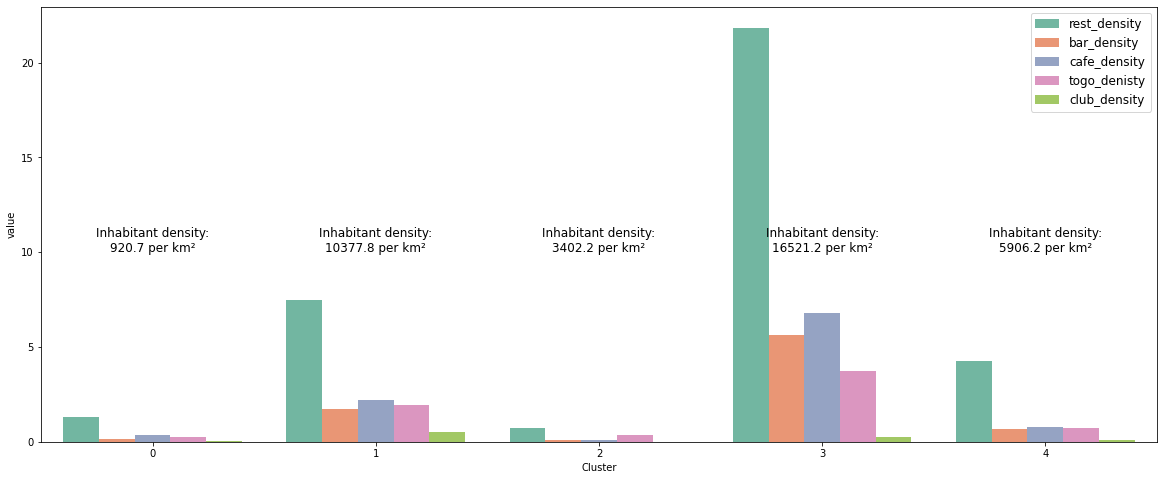

In [33]:
fig, ax = plt.subplots(figsize=(20, 8))
test = interpretation.iloc[:,:-1].melt(id_vars='Cluster')
plt.rcParams['font.size'] = '12'
plt.xticks(list(range(5)))
sns.barplot(x='Cluster', y='value', hue='variable', data=test, palette='Set2')
plt.legend(loc='upper right')


for clust in interpretation['Cluster']:
    plt.annotate(xy = (clust,10),
                xytext = (clust,10),
                fontsize = 12,
                ha = 'center',
                s = 'Inhabitant density:\n{} per km²'.format(round(interpretation['inhabitant_density'][interpretation['Cluster'] == clust].iloc[0],1)))

In [ ]:
Naming Clusters:

In [789]:
Cluster_0 = 'No gastronomy, sparse population'
Cluster_1 = 'Various gastronomy, populated area'
Cluster_2 = 'Little gastronomy, little population'
Cluster_3 = 'Large and various gastronomy, populational hotspot'
Cluster_4 = 'Large and various gastronomy, populational hotspot'

In [36]:
hamburg_rest = hamburg_gastro[hamburg_gastro['Restaurant'] == 1]
hamburg_bar = hamburg_gastro[hamburg_gastro['Bar'] == 1]
hamburg_cafe = hamburg_gastro[hamburg_gastro['Cafe'] == 1]
hamburg_togo = hamburg_gastro[hamburg_gastro['To_Go'] == 1]
hamburg_club = hamburg_gastro[hamburg_gastro['Club'] == 1]

In [35]:
hamburg_rest.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Lat,Venue Lon,Restaurant,Bar,Cafe,To_Go,Club,Check,Distance
1506,3180,Wilhelmsburg,53.495893,10.003765,Wilhelms im Wälderhaus,Restaurant,53.496094,10.002784,1,0,0,0,0,1,0.068663
1386,2929,Sternschanze,53.562476,9.965672,JILL,Pizza Place,53.562057,9.964898,1,0,0,0,0,1,0.069142
667,1388,Harburg,53.461322,9.985303,Steakhammer,Steakhouse,53.461342,9.984244,1,0,0,0,0,1,0.070172
564,1184,Hamburg-Altstadt,53.549777,9.996656,Picasso,Spanish Restaurant,53.549934,9.995627,1,0,0,0,0,1,0.070176
914,1992,Neustadt,53.551697,9.981752,Zum Spätzle,Swabian Restaurant,53.551033,9.981608,1,0,0,0,0,1,0.074558


We further compute the distance to city centers, to account for differtial density of city districts.

In [62]:
hamburg_clean['dist_center'] = pd.NA

distances = []
R = 6373.0
for lat, lon in zip(hamburg_clean['lat'], hamburg_clean['lon']):
    dlon = radians(9.9937) - radians(lon)
    dlat = radians(53.5511) - radians(lat)
    a = sin(dlat / 2)**2 + cos(53.5511) * cos(lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    distances.append(distance)

hamburg_clean['dist_center'] = distances

In [66]:
hamburg_clean.sort_values('dist_center', ascending = True).head(20)

,Stadtgebiet,Bezirk,Fläche,geometry,lat,lon,dist_center
34,Hamburg-Altstadt,Hamburg-Mitte,1.300347,"POLYGON ((9.99812 53.55697, 9.99837 53.55693, ...",53.549777,9.996656,0.357099
66,Neustadt,Hamburg-Mitte,2.261902,"POLYGON ((9.98952 53.55997, 9.99009 53.55980, ...",53.551697,9.981752,1.316875
80,Rotherbaum,Eimsbüttel,2.735309,"POLYGON ((10.00822 53.56523, 10.00412 53.56227...",53.566718,9.991795,1.749774
33,HafenCity,Hamburg-Mitte,2.425612,"POLYGON ((10.00857 53.54443, 10.00913 53.54397...",53.539757,10.004901,1.764745
85,St. Georg,Hamburg-Mitte,1.822657,"POLYGON ((10.01565 53.56150, 10.01584 53.56140...",53.556738,10.012495,2.161020
49,Kleiner Grasbrook,Hamburg-Mitte,5.950088,"POLYGON ((10.02212 53.53255, 10.02144 53.53180...",53.528671,9.998343,2.546745
86,St. Pauli,Hamburg-Mitte,2.242488,"POLYGON ((9.98394 53.56371, 9.98404 53.56369, ...",53.554673,9.968408,2.811622
38,Harvestehude,Eimsbüttel,2.050524,"POLYGON ((9.99281 53.58512, 9.99310 53.58507, ...",53.577693,9.987904,3.025690
89,Sternschanze,Altona,0.548449,"POLYGON ((9.97168 53.56657, 9.97217 53.56632, ...",53.562476,9.965672,3.332266
36,Hammerbrook,Hamburg-Mitte,2.495987,"POLYGON ((10.02995 53.55112, 10.03006 53.55100...",53.546276,10.025234,3.513613


In [2]:
tm = folium.Map(
    location=[53.5511, 9.9937],
    zoom_start=10,)

folium.GeoJson(hamburg_total,
    style_function = lambda x: {
        'fillColor': 'white',
        'color': 'black',
        'opacity': 1,
        'weight' : 1,
        'fillOpacity': 1}).add_to(tm)

for name, area, lat, lng, dist_center in zip(hamburg_clean['Stadtgebiet'], hamburg_clean['Fläche'], hamburg_clean['lat'], hamburg_clean['lon'], hamburg_clean['dist_center']):
    radius =  int(sqrt(area / math.pi) * 1000)
    
    if radius < 5:
        radius = radius*1.1
    if radius > 5:
        radius = radius*1.4

    folium.Circle(location=(lat,lng),
                            radius= radius,
                            weight = 2,
                            color = "#007849",
                            fill = "#007849",
                            fill_opacity = 0.2).add_to(tm)

tm

NameError: name 'hamburg_total' is not defined

In [70]:
#continous_map(hamburg_total, 'Cluster')

minima = min(hamburg_total['Cluster'])
maxima = max(hamburg_total['Cluster'])

step = cmp.StepColormap(
    ['pink','green','yellow','blue','red'], #,'yellow','red','white','orange','black','magenta'],
    index = [-1,0,1,2,3,4,5], #,5,6,7,8,9,10],
    vmin=minima, vmax=maxima,
    caption='Inhabitant Density') #Caption for Color scale or Legend)

m = folium.Map(
    location=[53.5511, 9.9937],
    zoom_start=10,)

layer1 = folium.FeatureGroup(name="Neighborhoods") 

layer1.add_child(folium.GeoJson(hamburg_total,
    style_function = lambda x: {
        'fillColor': step(x['properties']['Cluster']),
        'color': 'black',
        'opacity': 0.3,
        'weight' : 1,
        'fillOpacity': 0.5},
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['stadtteil', 'Bevölkerungs-dichte', 'rest_density', 'bar_density', 'cafe_density', 'togo_denisty','club_density','Cluster'],
        aliases = ['Neighborhood: ', 'Inhabitant density (per km²): ','Restaurant density (per km²): ', 'Bar Density (per km²): ', 'Café Density (per km²): ', 'To Go Density (per km²): ', 'Club Density (per km²): ','Cluster: '])))
        
m.add_child(layer1)

layer2 = folium.FeatureGroup(name="Restaurants") 

for name,cat,lat,lon in zip(hamburg_rest['Venue Name'], hamburg_rest['Venue Category'], hamburg_rest['Venue Lat'], hamburg_rest['Venue Lon']):
    layer2.add_child(folium.CircleMarker(
            location=[lat, lon],
            color = 'green',
            radius = 3,
            popup='{}: {}'.format(name,cat),
            #icon=folium.Icon(color = 'green', icon='cocktail', prefix='fa')
            ))
    m.add_child(layer2)

layer3 = folium.FeatureGroup(name="Bars") 

for name,cat,lat,lon in zip(hamburg_bar['Venue Name'], hamburg_bar['Venue Category'], hamburg_bar['Venue Lat'], hamburg_bar['Venue Lon']):
    layer3.add_child(folium.CircleMarker(
            location=[lat, lon],
            color = 'red',
            radius = 3,
            popup='{}: {}'.format(name,cat),
            #icon=folium.Icon(color = 'red', icon='cocktail', prefix='fa')
            ))
    m.add_child(layer3)

layer4 = folium.FeatureGroup(name="Cafés") 

for name,cat,lat,lon in zip(hamburg_cafe['Venue Name'], hamburg_cafe['Venue Category'], hamburg_cafe['Venue Lat'], hamburg_cafe['Venue Lon']):
    layer4.add_child(folium.CircleMarker(
            location=[lat, lon],
            color = 'blue',
            radius = 3,
            popup='{}: {}'.format(name,cat),
            #icon=folium.Icon(color = 'blue', icon='cocktail', prefix='fa')
            ))
    m.add_child(layer4)

layer5 = folium.FeatureGroup(name="To Go") 

for name,cat,lat,lon in zip(hamburg_togo['Venue Name'], hamburg_togo['Venue Category'], hamburg_togo['Venue Lat'], hamburg_togo['Venue Lon']):
    layer5.add_child(folium.CircleMarker(
            location=[lat, lon],
            color = 'orange',
            radius = 3,
            popup='{}: {}'.format(name,cat),
            #icon=folium.Icon(color = 'orange', icon='cocktail', prefix='fa')
            ))
    m.add_child(layer5)

layer6 = folium.FeatureGroup(name="Clubs") 

for name,cat,lat,lon in zip(hamburg_club['Venue Name'], hamburg_club['Venue Category'], hamburg_club['Venue Lat'], hamburg_club['Venue Lon']):
    layer6.add_child(folium.CircleMarker(
            location=[lat, lon],
            color = 'black',
            radius = 3,
            popup='{}: {}'.format(name,cat),
            #icon=folium.Icon(color = 'black', icon='cocktail', prefix='fa'),
            ))
    m.add_child(layer6)


#m.add_child(layer1)
m.add_child(folium.LayerControl())

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:20px; right: 30px; bottom: 30px;'>
     
<div class='legend-title'>Hamburg Neighborhoods clustered</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:pink;opacity:0.7;'></span>Cluster 1: No gastronomy, sparsely populated</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 2: Various gastronomy, highly populated </li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 3: Little gastronomy, average population</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 4: Large and various gastronomy, populational hotspot</li>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 5: XXX</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)


KeyError: 'Cluster'

<br>
<br>
<br>

# Part III: Clustering in Toronto

Setting credentials for Foursquare

Transforming the dataframe, so that each Neighborhood gets its own column. For this, I iterate over each row and count the number of Commas in the Neighborhood column. Per Comma, I add one row with the  Neighborhood after the respective Comma. 

In [363]:
print('Our Dataframe has now {} rows instead of {}.'.format(toronto.shape[0], toronto_hoods.shape[0]))

Our Dataframe has now 216 rows instead of 103.


We now extract all gastronomical keywords from the categories obtained in the NYC Lab, to determine which categories are actually gastronomical.

In [510]:
keywords = ['Restaurant','BBQ','Bagel','Bakery','Bar','Beer','Bistro','Tea','Beakfast','Burger','Joint','Burrito','Café','Coffee','Cocktail','Deli','Bodega','Diner','Fish','Food','Drink','Chicken','Yoghurt','Pub','Gastropub','Club','Pizza','Place','Poke','Salad','Steak', 'Sushi','Wine']

With this code, I retrieve the restaurants from Foursquare for each individual Neighborhood. 

Here I save the dataframe, in order to not having to retrieve the Foursquare API again. 

In [34]:
toronto_venues.to_csv('toronto_venues.csv')

Check if venue category contains a gastro keyword and store that information in a new column.

In [53]:
for i, cat in enumerate(toronto_venues['Venue Category']):
    c = 0
    for word in keywords: 
        if word.lower() in cat.lower() and c == 0:
            toronto_venues.loc[i,'Gastro'] = 1
            c += 1
    

Creating a new Dataframe that only contains gastro categories

In [55]:
toronto_gastro = toronto_venues[toronto_venues['Gastro'] == 1]

In [366]:
toronto_gastro.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Gastro
2,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop,1.0
4,Victoria Village,43.725882,-79.315572,Portugril,Portuguese Restaurant,1.0
5,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop,1.0
6,Victoria Village,43.725882,-79.315572,Pizza Nova,Pizza Place,1.0
7,Regent Park,43.654260,-79.360636,Roselle Desserts,Bakery,1.0


Dummy-coding venue categories

In [57]:
toronto_dummy = pd.get_dummies(toronto_gastro[['Venue Category']], prefix="", prefix_sep="")
toronto_dummy['Neighborhood'] = toronto_gastro['Neighborhood']


In [58]:
toronto_dummy.head()

,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,...,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Neighborhood
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Regent Park


Creating the final dataframe for which I merge the Dataframe with single Neighborhoods with Postcode and Borough information

In [260]:
toronto_final = toronto[['Neighborhood','PostalCode','Borough']].merge(toronto_gastro[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']].drop_duplicates(), how = 'left', left_on = 'Neighborhood', right_on = 'Neighborhood', copy = False)
toronto_final = toronto_final.merge(toronto_grouped['Neighborhood'], how = 'right', left_on = 'Neighborhood', right_on = 'Neighborhood')

##Exluding the Neighborhoods that appeared more often in the dataframe.The Neighborhoods that are duplicated are extracted, and then every second entry from the resulting list is exlcuded. This way, only one entry remains, when a Neighborhood occurs twice. This process is repeated two times to account for the case, that a Neighborhood occurs more than twice
toronto_final = toronto_final.drop(list(toronto_final[toronto_final.duplicated(subset=['Neighborhood'],keep=False)].Neighborhood.index)[::2], axis = 0)
toronto_final = toronto_final.drop(list(toronto_final[toronto_final.duplicated(subset=['Neighborhood'],keep=False)].Neighborhood.index)[::2], axis = 0)

In [240]:
toronto_final.head(10)

,Neighborhood,PostalCode,Borough,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,M3A,North York,43.753259,-79.329656
1,Victoria Village,M4A,North York,43.725882,-79.315572
2,Regent Park,M5A,Downtown Toronto,43.654260,-79.360636
3,Harbourfront,M5A,Downtown Toronto,43.654260,-79.360636
4,Lawrence Manor,M6A,North York,43.718518,-79.464763
5,Lawrence Heights,M6A,North York,43.718518,-79.464763
6,Ontario Provincial Government,M7A,Queen's Park,43.662301,-79.389494
7,Malvern,M1B,Scarborough,43.806686,-79.194353
8,Rouge,M1B,Scarborough,43.806686,-79.194353
9,Don Mills North,M3B,North York,43.745906,-79.352188


Creating a Dataframe for Clustering by grouping the dummy-coded dataframe by Neighborhoods

In [241]:
toronto_grouped = toronto_dummy.groupby('Neighborhood').mean().reset_index()



In [242]:
toronto_grouped.head()

,Neighborhood,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,...,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Adelaide,0.0,0.033898,0.016949,0.0,0.0,0.016949,0.016949,0.0,0.00,...,0.0,0.0,0.050847,0.0,0.0,0.0,0.016949,0.0,0.0,0.0
1,Albion Gardens,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.20,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Bathurst Quay,0.5,0.000000,0.000000,0.0,0.0,0.000000,0.500000,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Beaumond Heights,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.20,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Bloordale Gardens,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.25,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Clustering the Neighborhoods based on the relative proportion of venue categories appearing in each Neighborhood

In [62]:
from sklearn.cluster import KMeans
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(toronto_grouped_clustering)

#Shwoing the clustering labels
kmeans.labels_[0:10] 

array([0, 3, 1, 3, 0, 0, 0, 2, 4, 0], dtype=int32)

Inserting the Clustering Labels into my final Dataframe

In [262]:

toronto_final.sort_values('Neighborhood', axis = 0, ascending = True, inplace = True)
toronto_final.insert(0, 'Cluster Labels', kmeans.labels_)


In [258]:
toronto_final.head()

,Cluster Labels,Neighborhood,PostalCode,Borough,Neighborhood Latitude,Neighborhood Longitude
44,0,Adelaide,M5H,Downtown Toronto,43.650571,-79.384568
151,3,Albion Gardens,M9V,Etobicoke,43.739416,-79.588437
138,1,Bathurst Quay,M5V,Downtown Toronto,43.628947,-79.394420
149,3,Beaumond Heights,M9V,Etobicoke,43.739416,-79.588437
25,0,Bloordale Gardens,M9C,Etobicoke,43.643515,-79.577201


Extending my final dataframe by Venue Name and Categories to further examine the Clusters

In [285]:
toronto_gastro_final = toronto_gastro.merge(toronto_final[['Cluster Labels', 'PostalCode', 'Borough','Neighborhood']], how = 'left', left_on = 'Neighborhood', right_on = 'Neighborhood', copy = True)

In [368]:
toronto_gastro_final.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Gastro,Cluster Labels,PostalCode,Borough
0,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop,1.0,0,M3A,North York
1,Victoria Village,43.725882,-79.315572,Portugril,Portuguese Restaurant,1.0,0,M4A,North York
2,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop,1.0,0,M4A,North York
3,Victoria Village,43.725882,-79.315572,Pizza Nova,Pizza Place,1.0,0,M4A,North York
4,Regent Park,43.654260,-79.360636,Roselle Desserts,Bakery,1.0,0,M5A,Downtown Toronto


### Examining all 5 Clusters:

I am doing this by counting the appearance of venue categories for each cluster (Limiting the output to 20 categories)

Cluster 1:

In [316]:
toronto_gastro_final.loc[toronto_gastro_final['Cluster Labels'] == 0, 'Venue Category'].value_counts().to_frame().iloc[:20,:].style.bar()



,Venue Category
Coffee Shop,340
Café,181
Restaurant,116
Italian Restaurant,72
Bakery,69
Pizza Place,69
Japanese Restaurant,67
Sushi Restaurant,53
Sandwich Place,53
Bar,51


In [317]:
#Naming Cluster 1: 
Cluster_1_name = 'High density: Various Gastronomy with a focus on Cafés'

Cluster 2:

In [311]:
toronto_gastro_final.loc[toronto_gastro_final['Cluster Labels'] == 1, 'Venue Category'].value_counts().to_frame().iloc[:20,:].style.bar()

,Venue Category
Bar,20
Airport Food Court,7


In [318]:
#Naming Cluster 2: 
Cluster_2_name = 'Low density: Bars & Airport'

Cluster 3:

In [312]:
toronto_gastro_final.loc[toronto_gastro_final['Cluster Labels'] == 2, 'Venue Category'].value_counts().to_frame().iloc[:20,:].style.bar()

,Venue Category
Bakery,9
Deli / Bodega,3


In [319]:
#Naming Cluster 3: 
Cluster_3_name = 'Low density: Bakery & Deli'

Cluster 4: 

In [314]:
toronto_gastro_final.loc[toronto_gastro_final['Cluster Labels'] == 3, 'Venue Category'].value_counts().to_frame().iloc[:20,:].style.bar()

,Venue Category
Pizza Place,34
Fast Food Restaurant,33
Sandwich Place,32
Fried Chicken Joint,11
Beer Store,9
Burrito Place,6
Burger Joint,6
Coffee Shop,6
Chinese Restaurant,6
Italian Restaurant,5


In [320]:
#Naming Cluster 4: 
Cluster_4_name = 'Medium density: Various Gastronomy with a focus on Fast Food and Restaurants'

Cluster 5:

In [315]:
toronto_gastro_final.loc[toronto_gastro_final['Cluster Labels'] == 4, 'Venue Category'].value_counts().to_frame().iloc[:20,:].style.bar()

,Venue Category
American Restaurant,3


In [321]:
#Naming Cluster 5: 
Cluster_5_name = 'Very low density: American Restaurants'

I append the generated Cluster Names to my final Dataframe

In [325]:
clusternames = [Cluster_1_name,Cluster_2_name,Cluster_3_name,Cluster_4_name,Cluster_5_name]
toronto_final['Cluster Names'] = pd.NA
for i in range(len(clusternames)):
    toronto_final['Cluster Names'][toronto_final['Cluster Labels'] == i] = clusternames[i]

In [326]:
toronto_final.head()

,Cluster Labels,Neighborhood,PostalCode,Borough,Neighborhood Latitude,Neighborhood Longitude,Cluster Names
44,0,Adelaide,M5H,Downtown Toronto,43.650571,-79.384568,High density: Various Gastronomy with a focus ...
151,3,Albion Gardens,M9V,Etobicoke,43.739416,-79.588437,Medium density: Various Gastronomy with a focu...
138,1,Bathurst Quay,M5V,Downtown Toronto,43.628947,-79.394420,Low density: Bars & Airport
149,3,Beaumond Heights,M9V,Etobicoke,43.739416,-79.588437,Medium density: Various Gastronomy with a focu...
25,0,Bloordale Gardens,M9C,Etobicoke,43.643515,-79.577201,High density: Various Gastronomy with a focus ...


Now I create a map of Toronto showing the clusters in different colours. In the popup, the Neighborhood Name and the respective Cluster Name are shown

In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [343]:
# Map with toronto coordinates
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, hood, cluster, cluster_names in zip(toronto_final['Neighborhood Latitude'], toronto_final['Neighborhood Longitude'], toronto_final['Neighborhood'], toronto_final['Cluster Labels'], toronto_final['Cluster Names']):
    html = '''<b>''' + str(hood) + '''</b> <br> <br>''' + str(cluster_names)
    iframe = folium.IFrame(html, width=200, height=200)
    label = folium.Popup(iframe, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The End.